# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [7]:
# can comment out after executing
#!curl -OL https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
#!unzip processed_celeba_small.zip
#!unzip processed-celeba-small.zip # pathが通らない

/bin/sh: 1: unzip: not found


In [8]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [12]:
# necessary imports
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [13]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader

    # resize and normalize the images
    transform = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [25]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

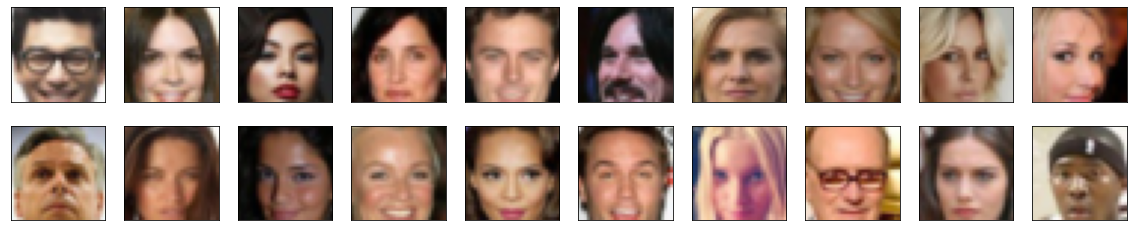

In [28]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
#    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

In [27]:
print(len(images))

128


#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [23]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    x = x * 2 - 1.0
    
    return x


In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9765)
Max:  tensor(0.9765)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [31]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(conv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
     
    # using Sequential container
    return nn.Sequential(*layers)

In [32]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim # This will be used in the flatten layer
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = x.view(-1, self.conv_dim*4*4*4)
        x = self.fc(x)
        
        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [33]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    # append conv layer
    layers.append(deconv_layer)

    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


In [35]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.fc = nn.Linear(z_size, 4*4*4*conv_dim)
        self.deconv1 = deconv(4*conv_dim, 2*conv_dim, 4)
        self.deconv2 = deconv(2*conv_dim, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        x = x.view(-1, self.conv_dim*4, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.tanh(self.deconv3(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [51]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    print(classname)
    
    # TODO: Apply initial weights to convolutional and linear layers
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [53]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Conv2d
Sequential
Conv2d
BatchNorm2d
Sequential
Conv2d
BatchNorm2d
Sequential
Linear
Discriminator
Linear
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
Sequential
Generator
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [55]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [56]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [57]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
        
            # 1.1. Train with real images

            # Compute the discriminator losses on real images 
            if train_on_gpu:
                real_images = real_images.cuda()
        
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
        
            # 1.2. Train with fake images
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
        
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
        
            # 2.1. Train with fake images and flipped labels
        
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
        
            # Compute the discriminator losses on fake images 
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
        
            # perform backprop
            g_loss.backward()
            g_optimizer.step()
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [58]:
# set number of epochs 
n_epochs = 30


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.9606 | g_loss: 3.5580
Epoch [    1/   30] | d_loss: 0.7320 | g_loss: 9.7421
Epoch [    1/   30] | d_loss: 0.4939 | g_loss: 2.3153
Epoch [    1/   30] | d_loss: 1.0586 | g_loss: 7.3602
Epoch [    1/   30] | d_loss: 0.9513 | g_loss: 7.8418
Epoch [    1/   30] | d_loss: 0.8443 | g_loss: 3.3565
Epoch [    1/   30] | d_loss: 0.6190 | g_loss: 4.0087
Epoch [    1/   30] | d_loss: 0.5006 | g_loss: 2.7855
Epoch [    1/   30] | d_loss: 0.5266 | g_loss: 3.4117
Epoch [    1/   30] | d_loss: 0.4259 | g_loss: 4.4295
Epoch [    1/   30] | d_loss: 0.8230 | g_loss: 3.1886
Epoch [    1/   30] | d_loss: 0.6740 | g_loss: 3.1059
Epoch [    1/   30] | d_loss: 0.6461 | g_loss: 3.0369
Epoch [    1/   30] | d_loss: 1.0045 | g_loss: 4.6493
Epoch [    1/   30] | d_loss: 0.8828 | g_loss: 2.0614
Epoch [    2/   30] | d_loss: 1.0708 | g_loss: 3.4571
Epoch [    2/   30] | d_loss: 0.8199 | g_loss: 2.6302
Epoch [    2/   30] | d_loss: 0.6389 | g_loss: 2.7399
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.8279 | g_loss: 1.6557
Epoch [   11/   30] | d_loss: 0.6348 | g_loss: 3.6293
Epoch [   11/   30] | d_loss: 0.6787 | g_loss: 3.3187
Epoch [   11/   30] | d_loss: 0.8028 | g_loss: 2.4483
Epoch [   11/   30] | d_loss: 0.6099 | g_loss: 2.3759
Epoch [   11/   30] | d_loss: 0.4061 | g_loss: 2.2315
Epoch [   11/   30] | d_loss: 0.6740 | g_loss: 2.0276
Epoch [   11/   30] | d_loss: 0.6024 | g_loss: 1.7299
Epoch [   11/   30] | d_loss: 0.6387 | g_loss: 1.9016
Epoch [   11/   30] | d_loss: 0.6280 | g_loss: 2.5967
Epoch [   11/   30] | d_loss: 0.5652 | g_loss: 1.2515
Epoch [   11/   30] | d_loss: 0.7733 | g_loss: 3.5436
Epoch [   11/   30] | d_loss: 0.9779 | g_loss: 3.2568
Epoch [   12/   30] | d_loss: 1.1504 | g_loss: 3.6403
Epoch [   12/   30] | d_loss: 0.7895 | g_loss: 3.1713
Epoch [   12/   30] | d_loss: 0.5529 | g_loss: 2.9805
Epoch [   12/   30] | d_loss: 0.8623 | g_loss: 1.2177
Epoch [   12/   30] | d_loss: 0.6153 | g_loss: 1.6923
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.3703 | g_loss: 2.8150
Epoch [   21/   30] | d_loss: 0.2494 | g_loss: 3.0280
Epoch [   21/   30] | d_loss: 0.4304 | g_loss: 3.1710
Epoch [   21/   30] | d_loss: 0.2465 | g_loss: 2.3249
Epoch [   21/   30] | d_loss: 0.2412 | g_loss: 3.3528
Epoch [   21/   30] | d_loss: 0.2208 | g_loss: 4.1760
Epoch [   21/   30] | d_loss: 0.2951 | g_loss: 3.0983
Epoch [   21/   30] | d_loss: 0.7754 | g_loss: 1.2235
Epoch [   21/   30] | d_loss: 0.3123 | g_loss: 3.7517
Epoch [   21/   30] | d_loss: 1.5782 | g_loss: 1.2205
Epoch [   21/   30] | d_loss: 0.3192 | g_loss: 2.2877
Epoch [   22/   30] | d_loss: 0.4593 | g_loss: 4.1402
Epoch [   22/   30] | d_loss: 0.5643 | g_loss: 4.3455
Epoch [   22/   30] | d_loss: 0.2556 | g_loss: 2.7653
Epoch [   22/   30] | d_loss: 0.3425 | g_loss: 2.2031
Epoch [   22/   30] | d_loss: 0.4085 | g_loss: 3.7321
Epoch [   22/   30] | d_loss: 0.2710 | g_loss: 2.9930
Epoch [   22/   30] | d_loss: 2.4464 | g_loss: 0.6457
Epoch [   22/   30] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

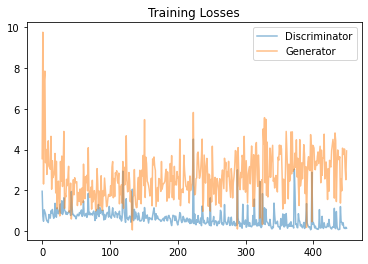

In [59]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [60]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [61]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

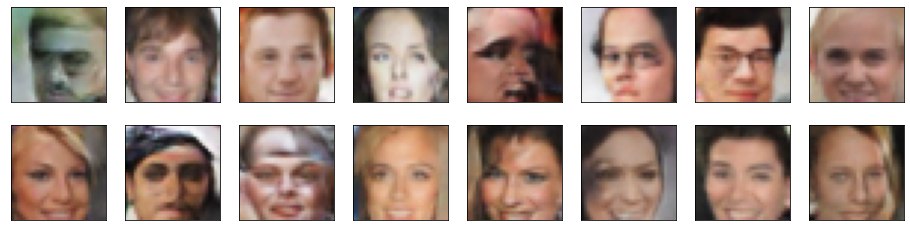

In [62]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

#### Dataset:
Refering the results, they looks also biased to white people, especially young women.  
In addition, most of results look laughing.  
To output higher quality and diverse results, data balancing shoud be considered using attribute of the dataset.  

#### Model size:
This time, I have used the original DCGAN model as well as I used it in another section for the mnist dataset.  
Increasing channels or layers might improve the quality of the model output.  
And the original DCGAN proposed in 2016 is a bit outdated, so we should try newer models and methods.  
For example, PGGAN(Progressive Growing of GANs) or Style GAN proposed by NVIDIA.  

#### Optimization strategy:
I've tried some additional experiment below, such as one-sided label smoothing, and Two time-scale Update Rule - TTUR.  
As for the first experiment, I couldn't get much better results by them, this time.  
On the other hand, I think the second experiment looks a bit better from the original  
Since a lot of methods were proposed to improve the performance of GANs, some of them should be tried.  
For example, Least-Squares GAN (LSGAN) can be used instead of using BCE (binary cross entropy).  
Also, bigger EPOC numbers should be tried.  

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.

---

## Additional experiment 1/2 (one-sided label smoothing)

In [80]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Conv2d
Sequential
Conv2d
BatchNorm2d
Sequential
Conv2d
BatchNorm2d
Sequential
Linear
Discriminator
Linear
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
Sequential
Generator
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding

In [81]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [82]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.9 # real labels = 0.9 (different from the original = 1.0)
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [83]:
import torch.optim as optim

# params
lr = 0.0002
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [84]:
# set number of epochs 
n_epochs = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.8843 | g_loss: 3.3718
Epoch [    1/   30] | d_loss: 0.7093 | g_loss: 5.3180
Epoch [    1/   30] | d_loss: 0.8538 | g_loss: 2.9612
Epoch [    1/   30] | d_loss: 0.8595 | g_loss: 5.0683
Epoch [    1/   30] | d_loss: 0.7904 | g_loss: 2.0565
Epoch [    1/   30] | d_loss: 0.8628 | g_loss: 5.1796
Epoch [    1/   30] | d_loss: 0.6423 | g_loss: 3.4588
Epoch [    1/   30] | d_loss: 1.1689 | g_loss: 1.5824
Epoch [    1/   30] | d_loss: 0.9564 | g_loss: 1.6132
Epoch [    1/   30] | d_loss: 0.7391 | g_loss: 3.0185
Epoch [    1/   30] | d_loss: 1.5948 | g_loss: 2.0296
Epoch [    1/   30] | d_loss: 0.8067 | g_loss: 2.3637
Epoch [    1/   30] | d_loss: 0.9674 | g_loss: 2.0954
Epoch [    1/   30] | d_loss: 1.3644 | g_loss: 4.0543
Epoch [    1/   30] | d_loss: 1.2342 | g_loss: 4.3154
Epoch [    2/   30] | d_loss: 1.8745 | g_loss: 2.0209
Epoch [    2/   30] | d_loss: 0.9953 | g_loss: 1.8749
Epoch [    2/   30] | d_loss: 0.8700 | g_loss: 1.7555
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.7700 | g_loss: 2.0624
Epoch [   11/   30] | d_loss: 0.8136 | g_loss: 1.8929
Epoch [   11/   30] | d_loss: 1.7427 | g_loss: 0.5838
Epoch [   11/   30] | d_loss: 0.8879 | g_loss: 1.4338
Epoch [   11/   30] | d_loss: 0.9399 | g_loss: 1.4760
Epoch [   11/   30] | d_loss: 0.6851 | g_loss: 1.6935
Epoch [   11/   30] | d_loss: 1.0220 | g_loss: 1.6601
Epoch [   11/   30] | d_loss: 0.7212 | g_loss: 1.4231
Epoch [   11/   30] | d_loss: 2.3167 | g_loss: 0.7794
Epoch [   11/   30] | d_loss: 0.9024 | g_loss: 2.1774
Epoch [   11/   30] | d_loss: 0.7602 | g_loss: 1.7749
Epoch [   11/   30] | d_loss: 0.7395 | g_loss: 2.0750
Epoch [   11/   30] | d_loss: 1.2957 | g_loss: 1.4118
Epoch [   12/   30] | d_loss: 0.9222 | g_loss: 2.6878
Epoch [   12/   30] | d_loss: 0.8230 | g_loss: 1.4608
Epoch [   12/   30] | d_loss: 0.8495 | g_loss: 1.1324
Epoch [   12/   30] | d_loss: 0.8219 | g_loss: 1.6524
Epoch [   12/   30] | d_loss: 0.8819 | g_loss: 2.4376
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.6362 | g_loss: 1.8375
Epoch [   21/   30] | d_loss: 0.6739 | g_loss: 3.3600
Epoch [   21/   30] | d_loss: 0.8617 | g_loss: 1.5156
Epoch [   21/   30] | d_loss: 0.6111 | g_loss: 1.6635
Epoch [   21/   30] | d_loss: 0.8980 | g_loss: 1.0562
Epoch [   21/   30] | d_loss: 0.5385 | g_loss: 2.4556
Epoch [   21/   30] | d_loss: 0.7517 | g_loss: 3.7158
Epoch [   21/   30] | d_loss: 4.2680 | g_loss: 1.0442
Epoch [   21/   30] | d_loss: 0.7784 | g_loss: 2.7807
Epoch [   21/   30] | d_loss: 0.6770 | g_loss: 1.8240
Epoch [   21/   30] | d_loss: 0.5684 | g_loss: 1.9676
Epoch [   22/   30] | d_loss: 0.6233 | g_loss: 2.0409
Epoch [   22/   30] | d_loss: 0.5935 | g_loss: 2.4134
Epoch [   22/   30] | d_loss: 0.6614 | g_loss: 2.8717
Epoch [   22/   30] | d_loss: 0.6735 | g_loss: 1.7669
Epoch [   22/   30] | d_loss: 0.7152 | g_loss: 2.0972
Epoch [   22/   30] | d_loss: 0.7183 | g_loss: 2.2108
Epoch [   22/   30] | d_loss: 0.6329 | g_loss: 1.8029
Epoch [   22/   30] | d_loss

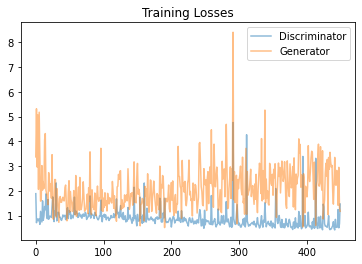

In [85]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [86]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [87]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

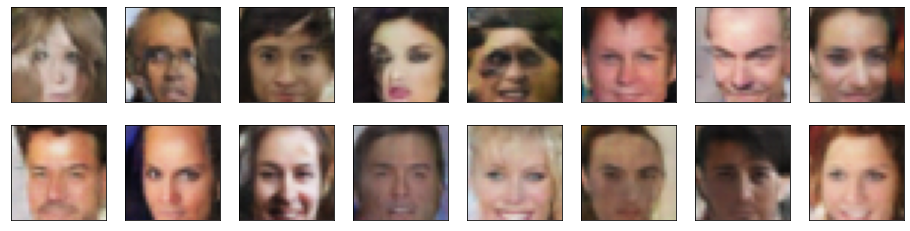

In [88]:
_ = view_samples(-1, samples)

## additional experiment 2/2 (Two time-scale Update Rule - TTUR)

In [95]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Conv2d
Sequential
Conv2d
BatchNorm2d
Sequential
Conv2d
BatchNorm2d
Sequential
Linear
Discriminator
Linear
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
BatchNorm2d
Sequential
ConvTranspose2d
Sequential
Generator
Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding

In [96]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


In [97]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [98]:
import torch.optim as optim

# params
lr_d = 0.00001 # set different learning rate b/w discriminator and generator
lr_g = 0.0005  # set different learning rate b/w discriminator and generator
beta1= 0.5
beta2= 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [99]:
# set number of epochs 
n_epochs = 30

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   30] | d_loss: 1.9445 | g_loss: 5.9470
Epoch [    1/   30] | d_loss: 0.4108 | g_loss: 8.3095
Epoch [    1/   30] | d_loss: 0.3869 | g_loss: 3.6960
Epoch [    1/   30] | d_loss: 0.9667 | g_loss: 7.8290
Epoch [    1/   30] | d_loss: 0.4012 | g_loss: 4.0735
Epoch [    1/   30] | d_loss: 0.4646 | g_loss: 3.7187
Epoch [    1/   30] | d_loss: 1.6422 | g_loss: 9.9464
Epoch [    1/   30] | d_loss: 0.4782 | g_loss: 3.2594
Epoch [    1/   30] | d_loss: 0.6021 | g_loss: 2.2625
Epoch [    1/   30] | d_loss: 0.9406 | g_loss: 2.1865
Epoch [    1/   30] | d_loss: 0.9105 | g_loss: 3.0222
Epoch [    1/   30] | d_loss: 0.5665 | g_loss: 3.3160
Epoch [    1/   30] | d_loss: 1.0236 | g_loss: 1.6604
Epoch [    1/   30] | d_loss: 0.5884 | g_loss: 2.6052
Epoch [    1/   30] | d_loss: 1.1348 | g_loss: 1.5472
Epoch [    2/   30] | d_loss: 1.2077 | g_loss: 4.0330
Epoch [    2/   30] | d_loss: 0.8487 | g_loss: 3.3166
Epoch [    2/   30] | d_loss: 1.4069 | g_loss: 0.7785
Epoch [    2/   30] | d_loss

Epoch [   11/   30] | d_loss: 0.7626 | g_loss: 1.4231
Epoch [   11/   30] | d_loss: 0.7503 | g_loss: 1.5994
Epoch [   11/   30] | d_loss: 0.5501 | g_loss: 1.7027
Epoch [   11/   30] | d_loss: 0.8133 | g_loss: 1.3753
Epoch [   11/   30] | d_loss: 0.6711 | g_loss: 1.9852
Epoch [   11/   30] | d_loss: 1.8462 | g_loss: 3.5158
Epoch [   11/   30] | d_loss: 0.6376 | g_loss: 1.9825
Epoch [   11/   30] | d_loss: 0.7691 | g_loss: 1.2826
Epoch [   11/   30] | d_loss: 0.8070 | g_loss: 2.7859
Epoch [   11/   30] | d_loss: 0.6188 | g_loss: 1.7952
Epoch [   11/   30] | d_loss: 0.6547 | g_loss: 1.9227
Epoch [   11/   30] | d_loss: 0.4881 | g_loss: 2.6289
Epoch [   11/   30] | d_loss: 2.3358 | g_loss: 7.1530
Epoch [   12/   30] | d_loss: 1.3293 | g_loss: 0.5985
Epoch [   12/   30] | d_loss: 0.4694 | g_loss: 2.5017
Epoch [   12/   30] | d_loss: 0.5052 | g_loss: 1.4178
Epoch [   12/   30] | d_loss: 0.3795 | g_loss: 2.3432
Epoch [   12/   30] | d_loss: 0.5197 | g_loss: 1.4960
Epoch [   12/   30] | d_loss

Epoch [   21/   30] | d_loss: 0.6770 | g_loss: 0.9606
Epoch [   21/   30] | d_loss: 0.4453 | g_loss: 2.4590
Epoch [   21/   30] | d_loss: 0.8355 | g_loss: 1.2460
Epoch [   21/   30] | d_loss: 0.4260 | g_loss: 2.0578
Epoch [   21/   30] | d_loss: 0.4567 | g_loss: 3.1389
Epoch [   21/   30] | d_loss: 0.2059 | g_loss: 3.1759
Epoch [   21/   30] | d_loss: 0.4124 | g_loss: 2.6497
Epoch [   21/   30] | d_loss: 0.2858 | g_loss: 3.8975
Epoch [   21/   30] | d_loss: 0.5972 | g_loss: 4.3296
Epoch [   21/   30] | d_loss: 0.2111 | g_loss: 3.3505
Epoch [   21/   30] | d_loss: 1.1166 | g_loss: 3.6471
Epoch [   22/   30] | d_loss: 1.0022 | g_loss: 0.6744
Epoch [   22/   30] | d_loss: 0.6046 | g_loss: 3.8555
Epoch [   22/   30] | d_loss: 0.2799 | g_loss: 2.7903
Epoch [   22/   30] | d_loss: 0.5158 | g_loss: 3.1432
Epoch [   22/   30] | d_loss: 0.3738 | g_loss: 3.0974
Epoch [   22/   30] | d_loss: 3.6165 | g_loss: 2.9425
Epoch [   22/   30] | d_loss: 0.2583 | g_loss: 3.7230
Epoch [   22/   30] | d_loss

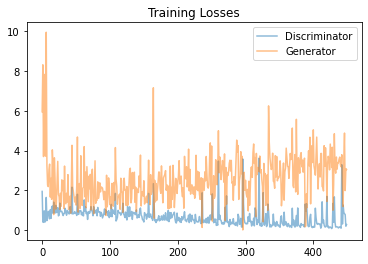

In [100]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [101]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [102]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

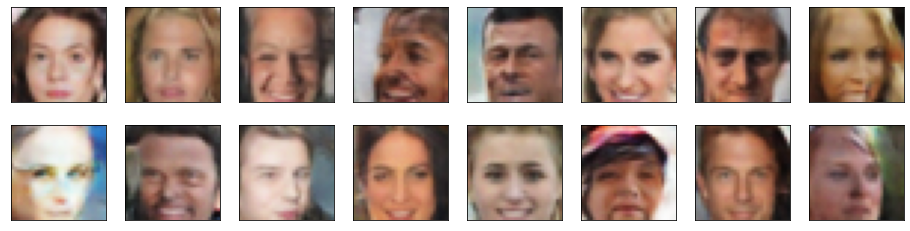

In [103]:
_ = view_samples(-1, samples)